# Correlation Analysis

Written by primarily by Joshua Kosnoff. MNE registration functions are heavily copied from MNE tutorials. Any additional credit is given in function headers 

To get a stable connectivity measurement for lower frequencies (i.e. theta; our main area of interest), we need to increase the epoch length. This means we have to start over with all of our preprocessing. We will do the exact same things, just with larger windows. For safety, I used -500 ms to 1500 ms. 

In [1]:
###################################################
# CHANGE THESE PATHS - the relative paths for box should be the same. You may need to change
# the relative FreeSurfer paths if you have different nomenclature or organization methods

path_to_file_paths = r"file_paths_remapped.json"
path_to_box = r"/Users/jkosnoff/Library/CloudStorage/Box-Box/Joshua-Speller-Paper/Data/EEG_Data/"

path_to_freesurfer = path_to_box + r'/Freesurfer'
path_to_freesurfer = r"/Users/jkosnoff/Docs/Freesurfer"

parse_mode = 'per_scan'
###################################################

### Preprocessing

## Source Extraction


Load in the preprocessed DF so we don't need to run that script again

In [2]:
import pandas as pd

preprocessed_df = pd.read_pickle(f"Analysis_Rerun.pkl")
preprocessed_df.head()

,subject,condition,data_epoch,hit
0,Subj01,Non-Modulated,"<EpochsArray | 1 events (all good), -0.2 – 0....",True
1,Subj01,Non-Modulated,"<EpochsArray | 1 events (all good), -0.2 – 0....",True
2,Subj01,Non-Modulated,"<EpochsArray | 1 events (all good), -0.2 – 0....",True
3,Subj01,Non-Modulated,"<EpochsArray | 1 events (all good), -0.2 – 0....",True
4,Subj01,Non-Modulated,"<EpochsArray | 1 events (all good), -0.2 – 0....",True


In [3]:
preprocessed_df.data_epoch.iloc[0]

Number of events,1
Events,1: 1
Time range,-0.200 – 0.500 s
Baseline,off


## EEG Source Imaging Extraction

The average series for each subject's V5, V1, superior parietal lobe, and inferior temporal gyrus is extracted using EEG source imaging techniques and their corresponding FreeSurfer labeled regions. 

In [4]:
# ESI functions, cribbed/repurposed from MNE Python tutorials
import os.path 
import json
import copy

# Third Party Packages
import statsmodels.stats.multitest
import itertools
from math import comb
import mne
from mne.preprocessing import ICA
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import shutil
import scipy
from scipy import stats

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import (make_axes_locatable, ImageGrid,
                                     inset_locator)


def make_digitization_fif(subject, subject_dir, path_to_vdhr, path_to_RAS, session_num = ""):
    raw = mne.io.read_raw_brainvision(path_to_vdhr,misc=['ECG', 'EMG', 'FootPad'],preload=False)
    mont = mne.channels.read_dig_localite(path_to_RAS)
    raw.set_montage(mont, match_case=False, on_missing='warn')
    raw.save(fr"{subject_dir}/{subject}_{session_num}_eeg.fif", overwrite=True)
    return

def auto_coregister(subject, subject_dir, subject_raw, plot_coreg = True, save_file = True, session_num=""):
    # Note: Before running this, you need to make the BEM model for the subject. See the FreeSurfer Protocol 
    # for the terminal commands on how to do this
    
    
    # Cribbed from https://mne.tools/dev/auto_tutorials/forward/25_automated_coreg.html.
    # Reformatted into a function by Joshua Kosnoff.
    info = mne.io.read_info(fr"{subject_dir}/{subject_raw}")
    plot_kwargs = dict(
        subject=subject,
        subjects_dir=subject_dir,
        surfaces="head",
        dig=True,
        eeg="projected",
        meg=[],
        show_axes=True,
        coord_frame="auto",
    )
    view_kwargs = dict(azimuth=30, elevation=90, distance=0.6, focalpoint=(0.0, 0.0, 0.0))

    fiducials = "auto"  # get fiducials from fsaverage
    
    coreg = mne.coreg.Coregistration(info, subject, subject_dir, fiducials=fiducials)
    coreg.omit_head_shape_points(distance=5.0 / 1000)  # distance is in meters
    coreg.fit_icp(n_iterations=30, nasion_weight=10.0, verbose=True)
    
    # Visualize the coregistration
    if plot_coreg:
        fig = mne.viz.plot_alignment(info, trans=coreg.trans, **plot_kwargs)
        mne.viz.set_3d_view(fig, **view_kwargs)

    # Save the file to the subject directory
    if save_file:
        mne.write_trans(fr'{subject_dir}/{subject}_{session_num}-trans.fif', coreg.trans, overwrite=True)
    
    return

def make_inv_operator(epoched_data, subj='default', 
                      subject_dir='default', 
                      coregistration='default', 
                      conductivity = (0.3, 0.006, 0.3), 
                      verbose = 'critical', SNR = 3, plot = False, 
                      domain = 'source'):
    """
    Create the source spaces and the inverse operator
    
    Inputs: 
        epoched_data: The EEG data in the type MNE Epochs()
        subj: subject name 
        subject_dir: The path to the subject directory 
        coregistration: the path to the -trans.fif file with MRI and EEG coregistation data
        SNR: signal-to-noise level. 3 is default based on MNE Python
        plot: whether to plot the source estimtes. 
        domain: 'source' or 'volume'
        
    Returns: 
        src: the source space data for the input domain
        inv_operator: the inverse operator
        lambda2: the regularization parameter based on SNR
    """
    
    # Silence all logs (semi-colons added on functions for good measure)
    mne.utils.use_log_level(verbose)
    mne.set_log_file(verbose)
    
    # If using default head models:
    if subj == 'default':
        path = str(mne.datasets.sample.data_path())
        subj = 'sample'
        subject_dir = path + r'/subjects'
        coregistration = path + r'/MEG/sample/sample_audvis_raw-trans.fif'
        
    elif coregistration == 'default':
        # Open GUI and get it?
        # write it to and load it from the subject_dir
        pass
    
    # Compute Noise Covariance Matrix
    noise_cov = mne.compute_covariance(
        epoched_data, tmax=0., method=['shrunk', 'empirical'], rank=None);
    
    # Make the BEM model
    model = mne.make_bem_model(subject=subj, ico=4,
                               conductivity=conductivity,
                               subjects_dir=subject_dir);
    bem = mne.make_bem_solution(model);
    
    if domain == 'source':
        src = mne.setup_source_space(subject=subj, spacing='oct6', add_dist='patch',
                             subjects_dir=subject_dir);
    
    elif domain == 'volume': 
        mri = os.path.join(subject_dir, subj, 'mri', 'T1.mgz')
        src = mne.setup_volume_source_space(
                    subject=subj, 
                    mri=mri,
                    bem=bem,
                    subjects_dir=subject_dir)
    

    # Compute the Forward Solution
    fwd = mne.make_forward_solution(epoched_data.info, trans=coregistration, src=src, bem=bem,
                                    meg=False, eeg=True, mindist=5.0, n_jobs=-1,);

    # Get Inverse Opterator
    evoked = epoched_data.average();
    
    inv_operator = mne.minimum_norm.make_inverse_operator(
        info=evoked.info, 
        forward = fwd, 
        noise_cov = noise_cov);

    # set signal-to-noise ratio (SNR) to compute regularization parameter (λ²)
    lambda2 = 1. / SNR ** 2
    
    return src, inv_operator, lambda2

In [5]:
import os.path as op

import mne
from mne.datasets import fetch_fsaverage
from mne.minimum_norm import apply_inverse_epochs, apply_inverse

mne.set_log_level('ERROR')

with open(path_to_file_paths) as f:
    file_paths = json.load(f)  
    
key_mappings = {"Decoupled-Sham": "Decoupled-Sham", "Non-Modulated":"Non-Modulated", 
           "tFUS-GC":"tFUS", "tFUS-GP": "US-Control"}

    
domain = 'source'
method = "MNE" # 'MNE', 'dSPM', 'sLORETA', and 'eLORETA'

connectivities = {}
granger_dfs = {}
all_data = {}

ESI_df = pd.DataFrame(columns = ["subject", "condition", "data", "order", "scan_num"])

for condition in ["tFUS-GC", "Non-Modulated", "Decoupled-Sham", "tFUS-GP"]:
    
    connectivities[condition] = []
    granger_dfs[condition] = []
    all_data[condition] = []
    
    for subject in list(file_paths.keys()):
        head_model = file_paths[subject]["head_model"]
        subjects_dir = path_to_freesurfer + file_paths[subject]["subject_dir"]
        session_num = file_paths[subject]["RAS"].split(r"/")[1]

        trans = subjects_dir + fr'/{head_model}_{session_num}-trans.fif'
        bem = subjects_dir + fr'/{head_model}_{session_num}-bem.fif'
        mri = op.join(subjects_dir, head_model, 'mri', 'T1.mgz')
        
        # Set up the source space (either volume or source)
        if domain == 'volume':
            src = mne.setup_volume_source_space(
                head_model, mri=mri, pos=10.0, bem=bem,
                subjects_dir=subjects_dir,
                add_interpolator=True,
                verbose=True)
        else:
            src = mne.setup_source_space(subject=head_model, spacing='oct6', add_dist='patch',
                                         subjects_dir=subjects_dir);

        try: 
            epoch = mne.concatenate_epochs(preprocessed_df["data_epoch"].loc[(preprocessed_df.subject == subject) 
                                                                             & (preprocessed_df.condition == condition)
                                                                             & (preprocessed_df.hit == True)
                                                                            ].to_list())
            epoch.set_eeg_reference('average', projection=True)
            
            
            # MAKE SURE THAT THE TMAX CORRESPONDS TO STIMULUS ONSET
            noise_cov = mne.compute_covariance(epoch, tmax=0.0, method=['shrunk', 'empirical'], rank=None);

            fwd = mne.make_forward_solution(epoch.info, trans=trans, src=src,
                                            bem=bem, eeg=True, meg=False, mindist=5.0, n_jobs=-1)

            # Inverse operator
            info = epoch.info
            inv = mne.minimum_norm.make_inverse_operator(info, fwd, noise_cov, loose=1, depth=0.8)

            # Calculate source time series 
            snr = 3.0
            lambda2 = 1.0 / snr ** 2
                        
            stcs = apply_inverse_epochs(epoch, inv, lambda2, method = 'MNE')
            

             # Get the labels of interest
            labels = []
            label_names = ["V1", "V5", "SP", "IT"]
            for parc, FS_region in zip(["BA_exvivo", "BA_exvivo", "aparc", "aparc"], 
                                       ["V1_exvivo-lh", "MT_exvivo-lh", "superiorparietal-lh", "inferiortemporal-lh"]):
                label = mne.read_labels_from_annot(head_model, parc=parc, 
                                                subjects_dir=subjects_dir, 
                                                regexp=FS_region)
                
                labels.append(label[0])
            
            # Extract Time series for labels of interest
            for i, stc in enumerate(stcs):
                ts = mne.extract_label_time_course(stcs = stc, 
                          labels = labels,
                          src=src)
                
                ts = np.stack(ts)
                ts = mne.filter.filter_data(ts, sfreq=100.0, l_freq=1, h_freq=40)
                 
                ESI_df.loc[len(ESI_df)] = {"subject": subject, "condition": condition, 
                           "data": ts, "scan_num": i + 1, 
                           "order": file_paths[subject]['order'][key_mappings[condition]]}
        
                
                all_data[condition].append(ts)
            
        except IndexError as e:
            print(subject, condition, e)


Subj12 Non-Modulated list index out of range
Subj01 Decoupled-Sham list index out of range
Subj04 Decoupled-Sham list index out of range
Subj06 Decoupled-Sham list index out of range
Subj07 Decoupled-Sham list index out of range
Subj09 Decoupled-Sham list index out of range
Subj15 Decoupled-Sham list index out of range
Subj02 tFUS-GP list index out of range
Subj01 tFUS-GP list index out of range
Subj04 tFUS-GP list index out of range
Subj07 tFUS-GP list index out of range
Subj11 tFUS-GP list index out of range
Subj13 tFUS-GP list index out of range
Subj16 tFUS-GP list index out of range
Subj19 tFUS-GP list index out of range


## Correlation Analysis

In [6]:
from Outlier_Tests import IQR_Outlier_test

data_dict_V5IT = {}
data_dict_V5SP = {}
data_dict_V5V1 = {}

power = 'alpha'

if power == 'theta':
    freq_bounds = [4, 8]
elif power == 'alpha':
    freq_bounds = [8, 12]

# Z-Score Baseline (-20 to 0 ms)
ESI_df['filtered_data'] = ESI_df['data'].apply(lambda x: (x - x[:,0:20].mean(axis=-1, keepdims=True))  / x[:,0:20].std(axis=-1, keepdims=True))


# connectivity_df = pd.DataFrame(columns = ['V5SP', 'V5IT', 'V5V1', 'SPV1', 'SPIT', 'V1IT', 'Condition', 'Time', 'Subject'])


connectivity_df = pd.DataFrame(columns = ['r', 'Connection', 'Condition', 'Subject', 'Time'])
method = 'coh'
mode = 'cwt_morlet'

with np.errstate(divide='ignore', invalid='ignore'):
   
    for i, subject in enumerate(np.unique(ESI_df['subject'])):
           
            
        for cond in np.unique(ESI_df['condition'].loc[ESI_df.subject == subject]):

            all_data = np.stack(ESI_df['filtered_data'].loc[(ESI_df.subject == subject) & (ESI_df.condition == cond)].values)

            V1_data = all_data[:, 0, :] # Stimulus onset to the end (500 ms)
            V5_data = all_data[:, 1, :]
            SP_data = all_data[:, 2, :]
            IT_data = all_data[:, 3, :]

            V1_data = mne.filter.filter_data(V1_data, sfreq=100.0, l_freq=freq_bounds[0], h_freq=freq_bounds[1])
            V5_data = mne.filter.filter_data(V5_data, sfreq=100.0, l_freq=freq_bounds[0], h_freq=freq_bounds[1])
            SP_data = mne.filter.filter_data(SP_data, sfreq=100.0, l_freq=freq_bounds[0], h_freq=freq_bounds[1])
            IT_data = mne.filter.filter_data(IT_data, sfreq=100.0, l_freq=freq_bounds[0], h_freq=freq_bounds[1])


            connection = "V5SP"
            cons = []

            for k in range(V5_data.shape[0]):
                cons.append(scipy.stats.pearsonr(V5_data[k], SP_data[k])[0])

            cons = np.abs(np.array(cons))

            # Drop Outliers
            cons = cons[~np.array(IQR_Outlier_test(cons))]
#                 cons = cons[double_mads_from_median(cons) < 3.5]

            for c in cons:

                connectivity_df.loc[len(connectivity_df)] = {"r": c,   
                                                             "Connection": connection,
                                                             "Condition": cond, "Subject": subject, 
                                                             "Time": 0}


            connection = "V5IT"
            cons = []

            for k in range(V5_data.shape[0]):
                cons.append(scipy.stats.pearsonr(V5_data[k], IT_data[k])[0])

            cons = np.abs(np.array(cons))

            # Drop Outliers
            cons = cons[~np.array(IQR_Outlier_test(cons))]
#                 cons = cons[double_mads_from_median(cons) < 3.5]

            for c in cons:

                connectivity_df.loc[len(connectivity_df)] = {"r": c,   
                                                             "Connection": connection,
                                                             "Condition": cond, "Subject": subject, 
                                                             "Time": 0}

            connection = "V5V1"
            cons = []

            for k in range(V5_data.shape[0]):
                cons.append(scipy.stats.pearsonr(V5_data[k], V1_data[k])[0])

            cons = np.abs(np.array(cons))

            # Drop Outliers
            cons = cons[~np.array(IQR_Outlier_test(cons))]
#                 cons = cons[double_mads_from_median(cons) < 3.5]

            for c in cons:

                connectivity_df.loc[len(connectivity_df)] = {"r": c,   
                                                             "Connection": connection,
                                                             "Condition": cond, "Subject": subject, 
                                                             "Time": 0}

            connection = "SPV1"
            cons = []

            for k in range(V5_data.shape[0]):
                cons.append(scipy.stats.pearsonr(V1_data[k], SP_data[k])[0])

            cons = np.abs(np.array(cons))

            # Drop Outliers
            cons = cons[~np.array(IQR_Outlier_test(cons))]
#                 cons = cons[double_mads_from_median(cons) < 3.5]

            for c in cons:

                connectivity_df.loc[len(connectivity_df)] = {"r": c,   
                                                             "Connection": connection,
                                                             "Condition": cond, "Subject": subject, 
                                                             "Time": 0}
            connection = "V1IT"
            cons = []

            for k in range(V5_data.shape[0]):
                cons.append(scipy.stats.pearsonr(V1_data[k], IT_data[k])[0])

            cons = np.abs(np.array(cons))

            # Drop Outliers
            cons = cons[~np.array(IQR_Outlier_test(cons))]
#                 cons = cons[double_mads_from_median(cons) < 3.5]

            for c in cons:

                connectivity_df.loc[len(connectivity_df)] = {"r": c,   
                                                             "Connection": connection,
                                                             "Condition": cond, "Subject": subject, 
                                                             "Time": 0}
            connection = "SPIT"
            cons = []

            for k in range(V5_data.shape[0]):
                cons.append(scipy.stats.pearsonr(IT_data[k], SP_data[k])[0])

            cons = np.abs(np.array(cons))

            # Drop Outliers
            cons = cons[~np.array(IQR_Outlier_test(cons))]
#                 cons = cons[double_mads_from_median(cons) < 3.5]

            for c in cons:

                connectivity_df.loc[len(connectivity_df)] = {"r": c,   
                                                             "Connection": connection,
                                                             "Condition": cond, "Subject": subject, 
                                                             "Time": 0}
                
for connection in np.unique(connectivity_df.Connection):
    connectivity_df.loc[connectivity_df.Connection == connection].to_csv(f"/Users/jkosnoff/Downloads/Rerun_{connection}_cor_{power}-IQR.csv")


## Make the Correlation Plots

Decoupled-Sham


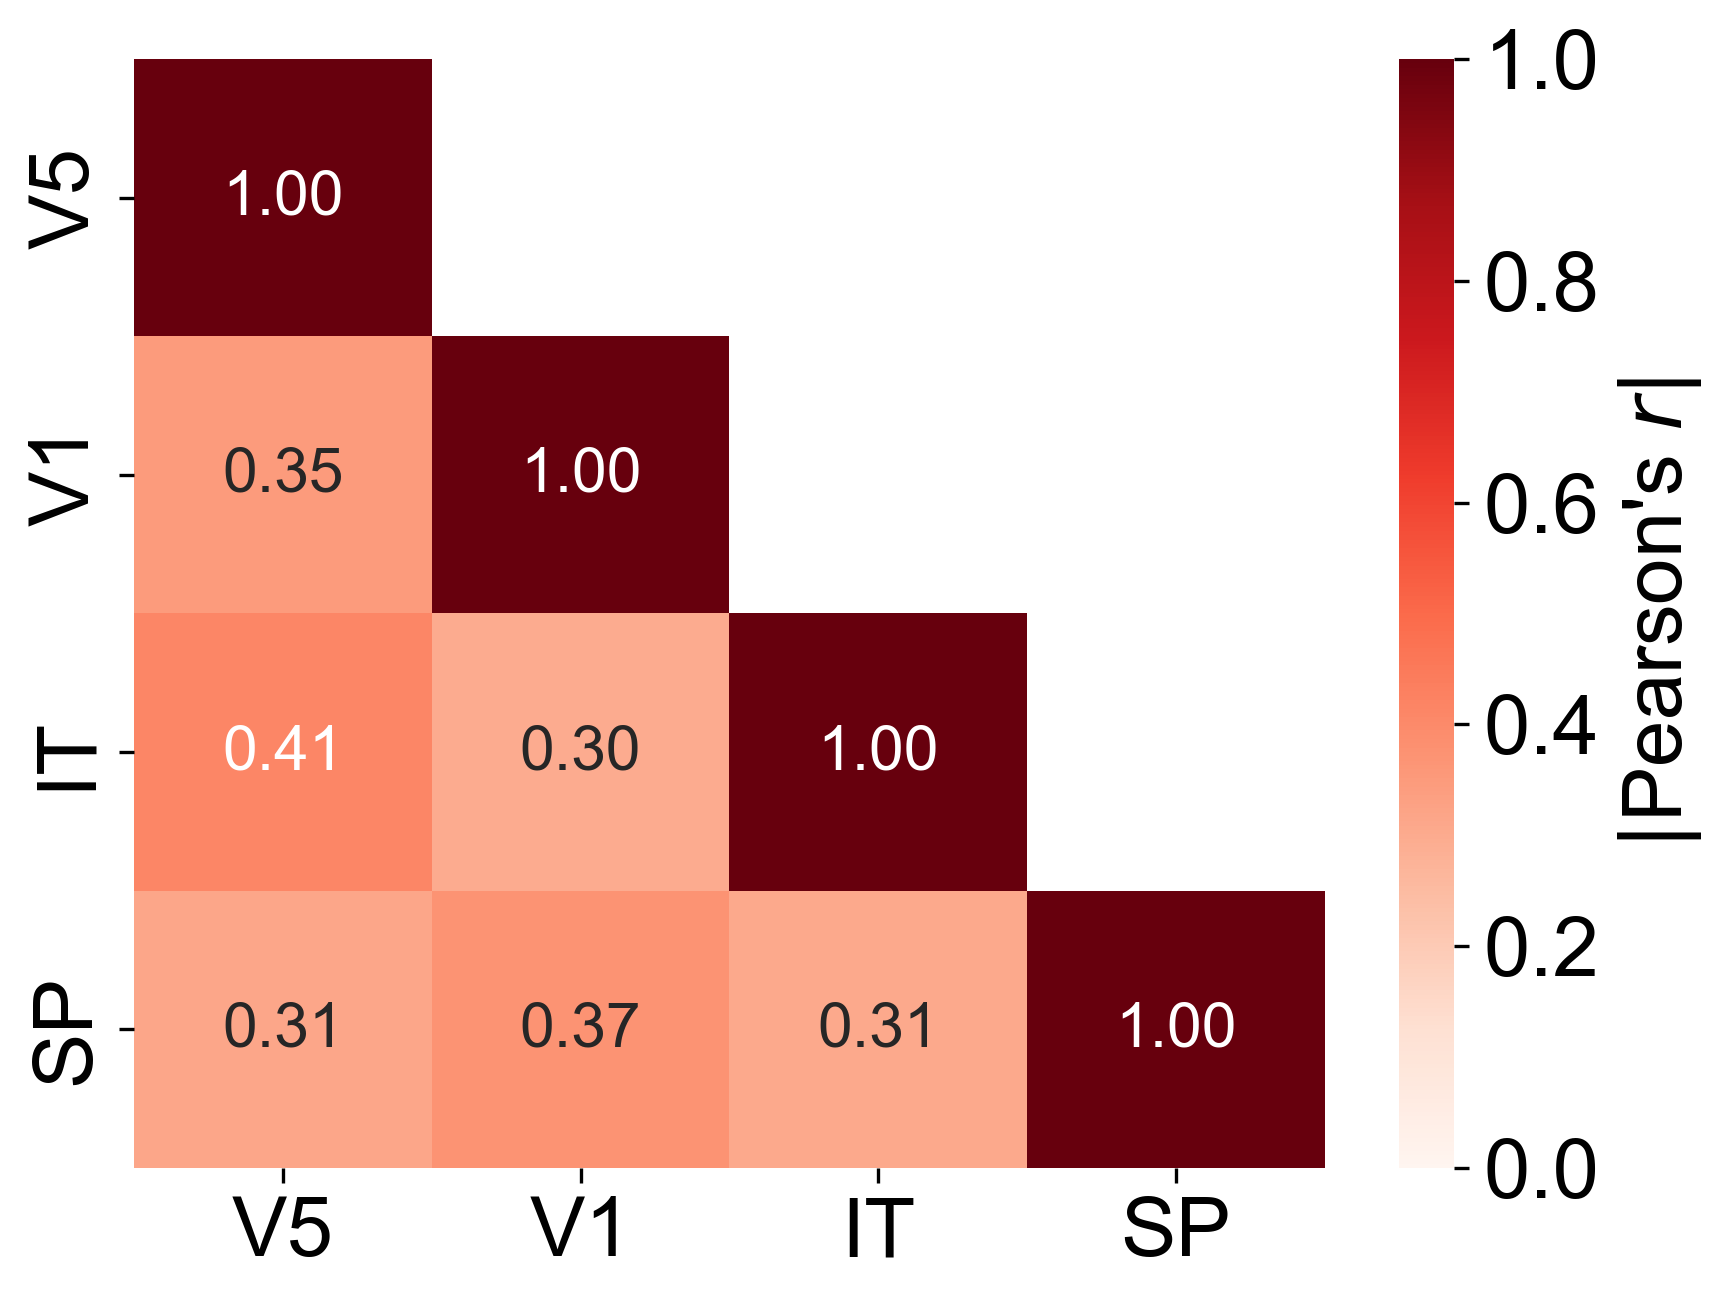

Non-Modulated


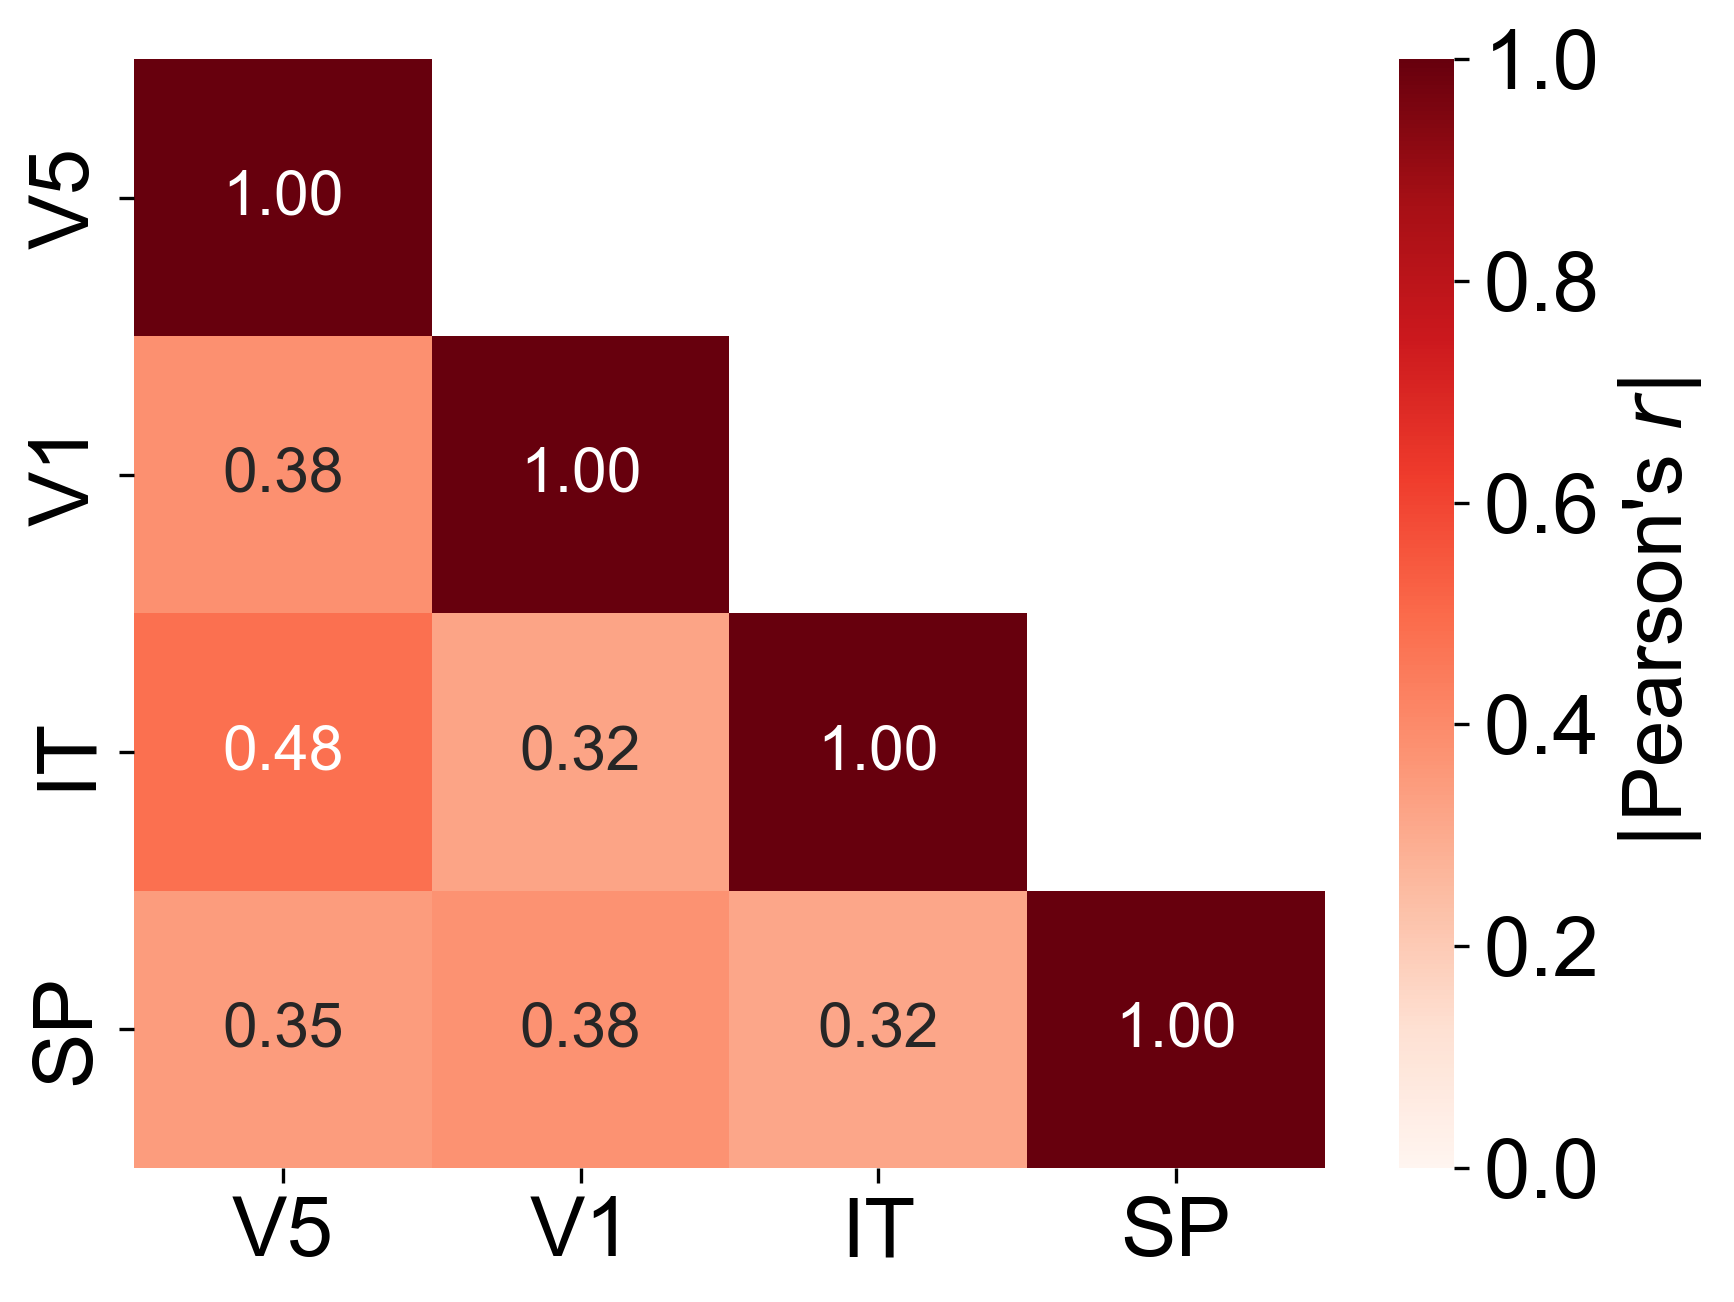

tFUS-GC


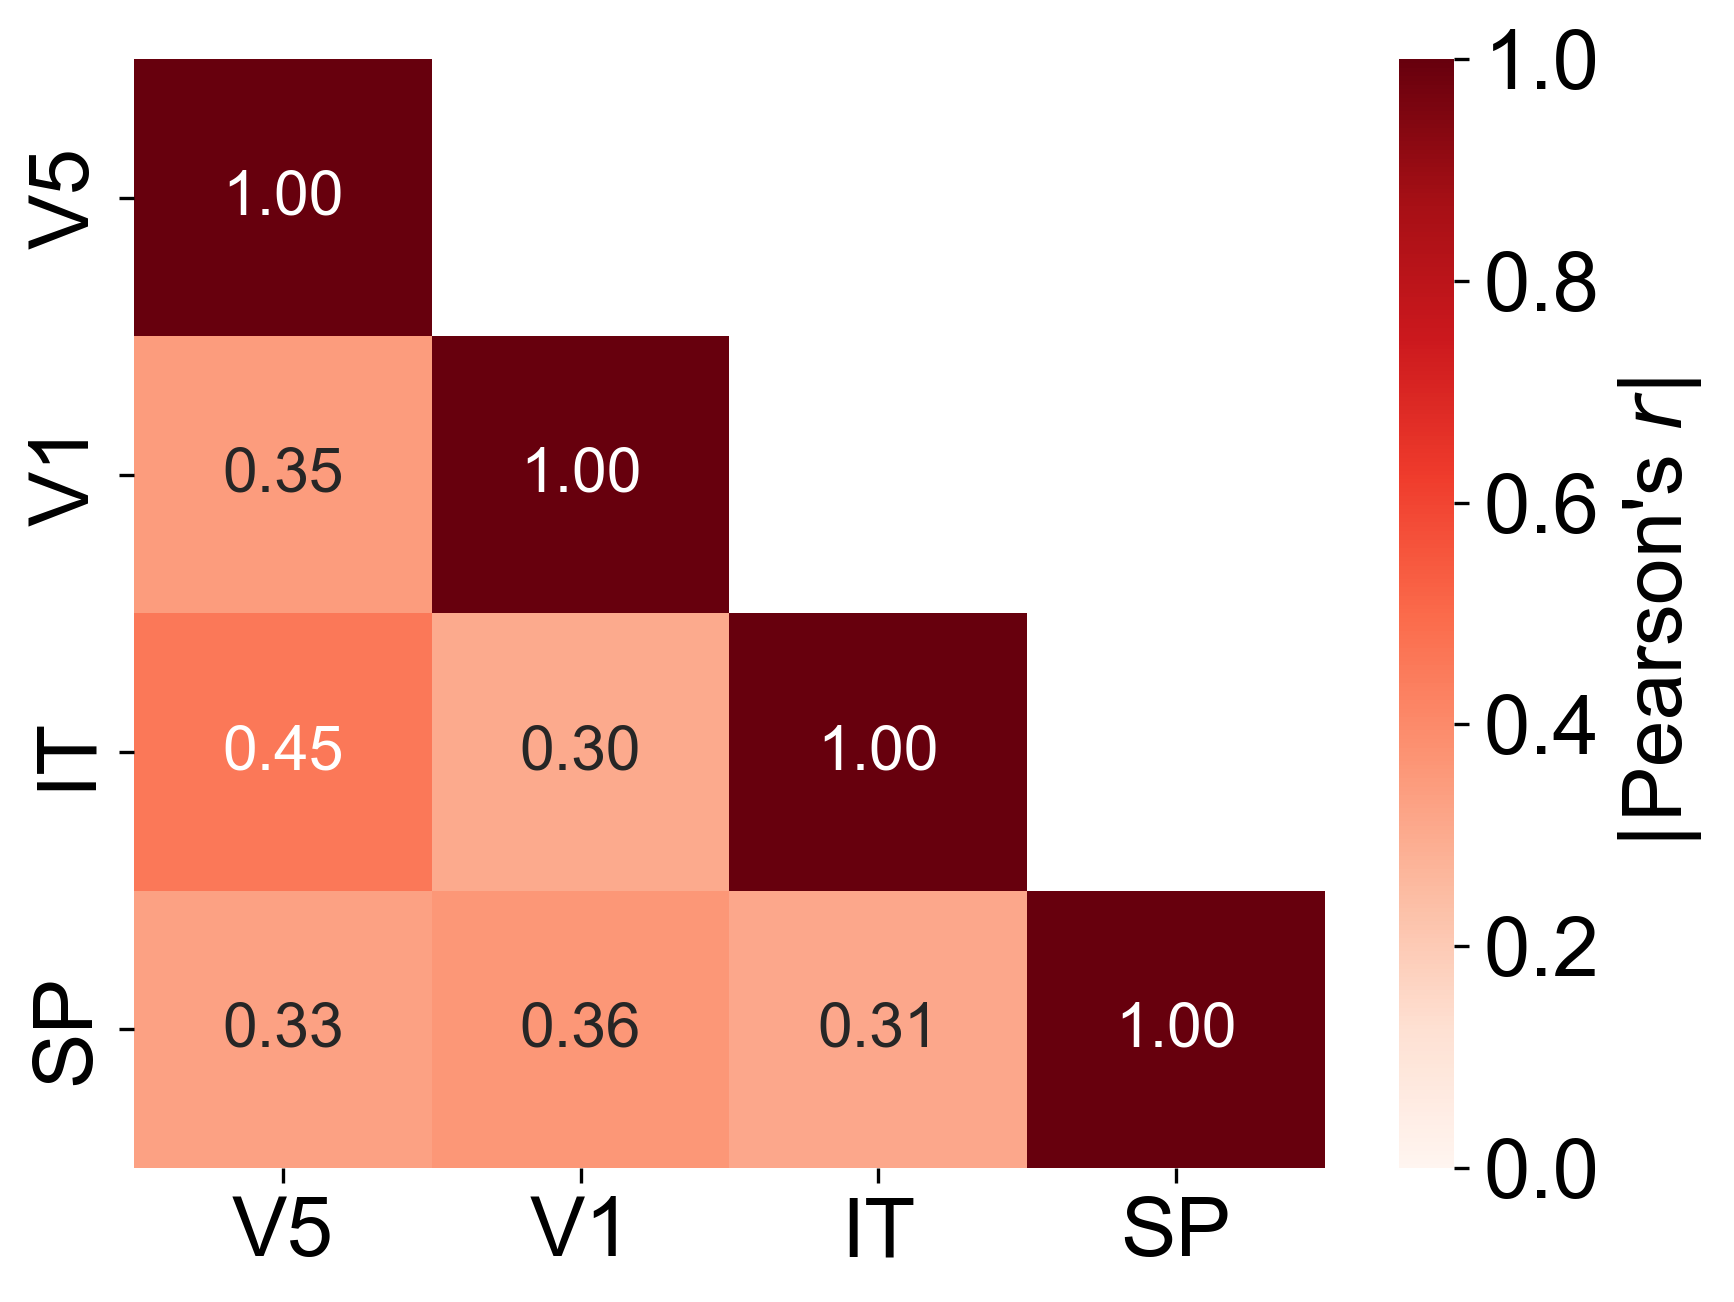

tFUS-GP


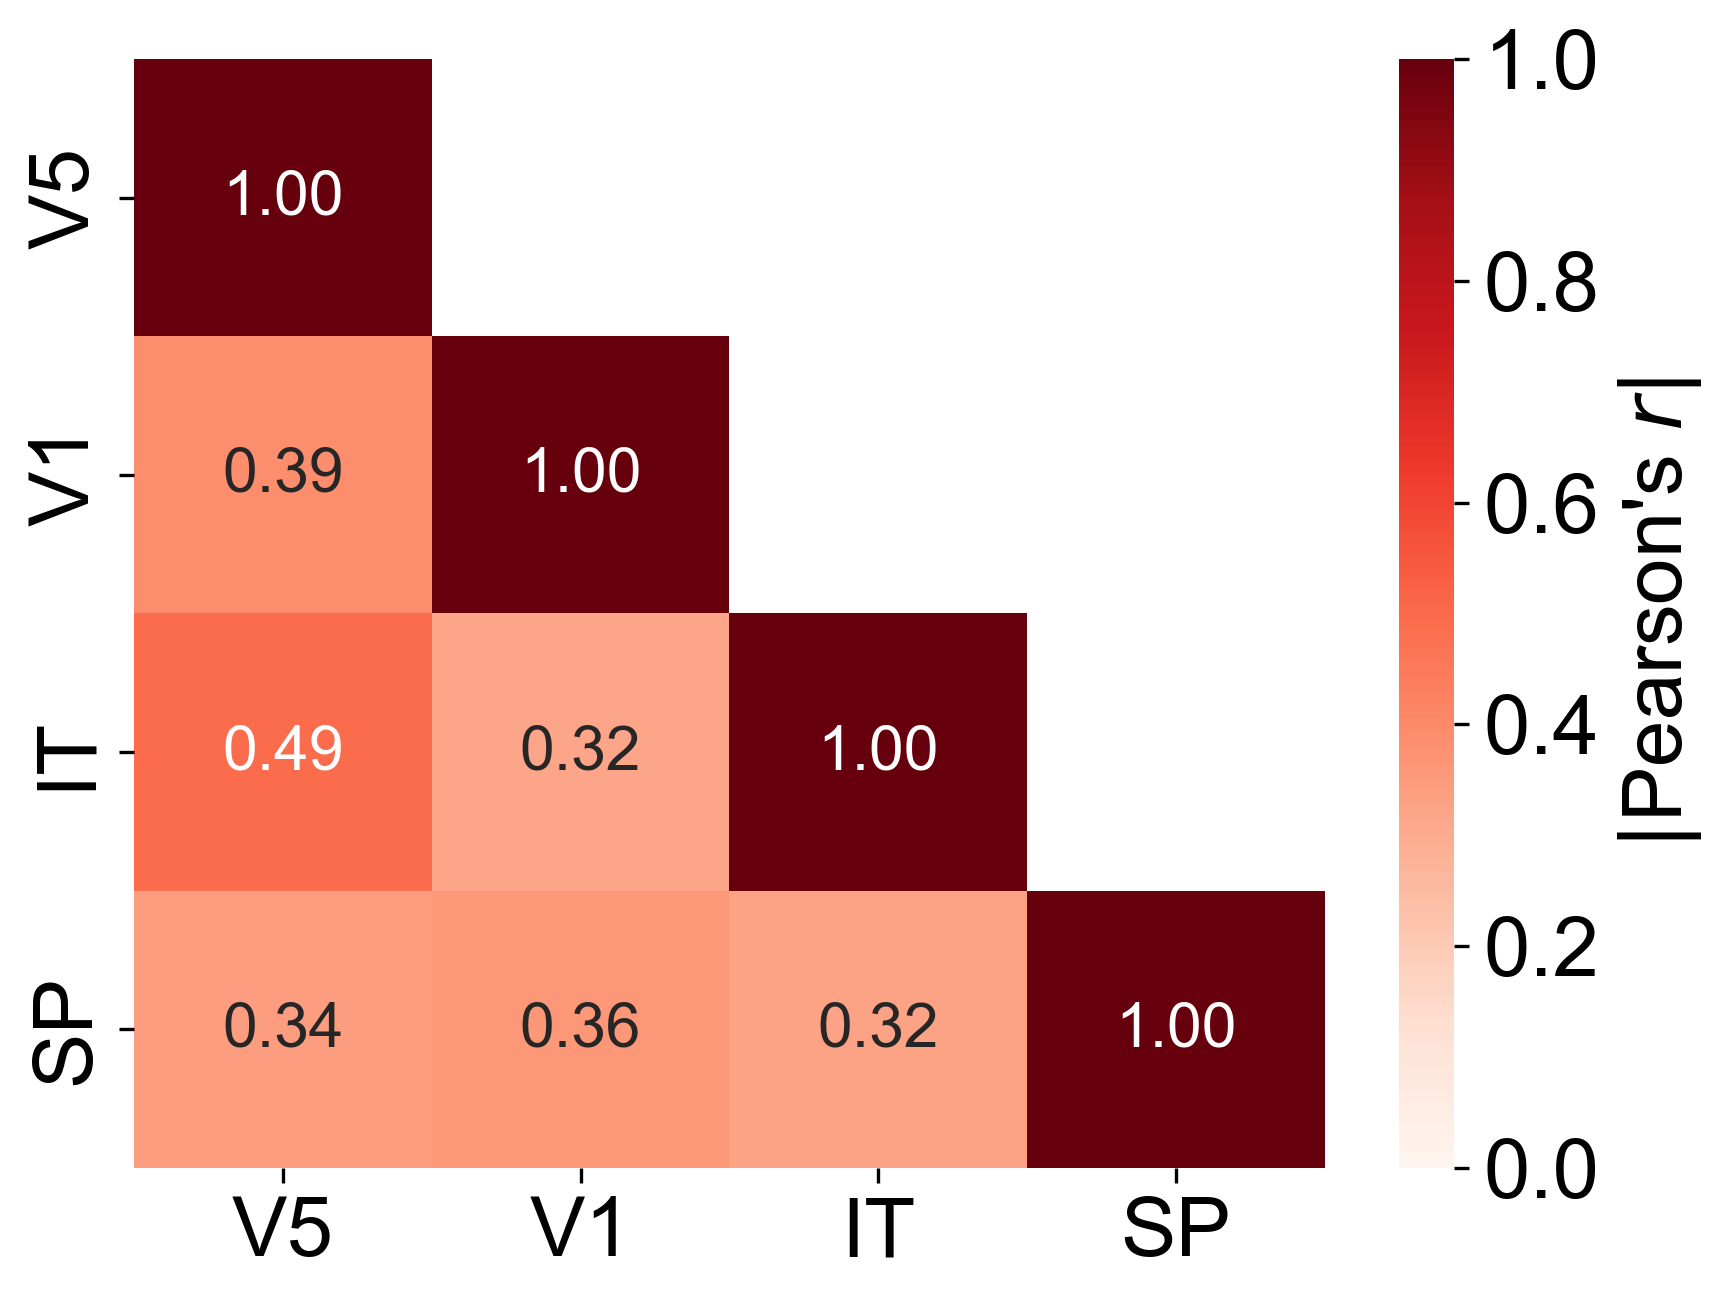

In [7]:
plt.rc('figure', dpi=300)
plt.rc('font', family='Arial', size=5)
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize 

def plot_corr(corr, title, names, cbar_label="", save_fig = ""):
    plt.figure()
    mask = np.triu(np.ones_like(corr))
    np.fill_diagonal(mask, False) 
    ax = sns.heatmap(corr, cmap = 'Reds', fmt = '.2f', vmin = 0, vmax = 1.0, annot = True, mask = mask, 
               cbar_kws={'label': cbar_label}, annot_kws={"size": 15})
    
    ax.figure.axes[-1].yaxis.label.set_size(20)    
    
    ax.set_xticks([i + 0.5 for i in range(len(names))])
    ax.set_xticklabels([i for i in names])
    ax.set_yticks([i + 0.5 for i in range(len(names))])
    ax.set_yticklabels([i for i in names]) 
    
    if save_fig:
        plt.savefig(save_fig, format = save_fig.split(".")[-1], dpi=300)
    
    plt.show()
    return

for condition in np.unique(connectivity_df.Condition):
    print(condition)
    V5SP = connectivity_df['r'].loc[(connectivity_df.Connection == 'V5SP') & (connectivity_df.Condition == condition)].mean()
    V5V1 = connectivity_df['r'].loc[(connectivity_df.Connection == 'V5V1') & (connectivity_df.Condition == condition)].mean()
    V5IT = connectivity_df['r'].loc[(connectivity_df.Connection == 'V5IT') & (connectivity_df.Condition == condition)].mean()
    
    V1IT = connectivity_df['r'].loc[(connectivity_df.Connection == 'V1IT') & (connectivity_df.Condition == condition)].mean()
    V1SP = connectivity_df['r'].loc[(connectivity_df.Connection == 'SPV1') & (connectivity_df.Condition == condition)].mean()
    SPIT = connectivity_df['r'].loc[(connectivity_df.Connection == 'SPIT') & (connectivity_df.Condition == condition)].mean()
    
    names = ['V5', 'V1', 'IT', 'SP']
    data = np.array([[1, np.nan, np.nan, np.nan], 
                     [V5V1, 1, np.nan, np.nan],
                     [V5IT, V1IT, 1, np.nan],
                     [V5SP, V1SP, SPIT, 1] ])
    
    plot_corr(data, title = '', names = names, cbar_label = "$|$Pearson's $r |$", save_fig=f"Corr_{condition}_{power}.svg")

## Statistical Comparison Plotting

[[(2, 4), 0.005032413], [(2, 1), 0.00843966], [(3, 4), 0.008427634], [(1, 3), 0.024097138]]
Comparison between tFUS-GC and tFUS-GP: 0.00503
Comparison between tFUS-GC and Non-Modulated: 0.00844
Comparison between Decoupled-Sham and tFUS-GP: 0.00843
Comparison between Non-Modulated and Decoupled-Sham: 0.02410


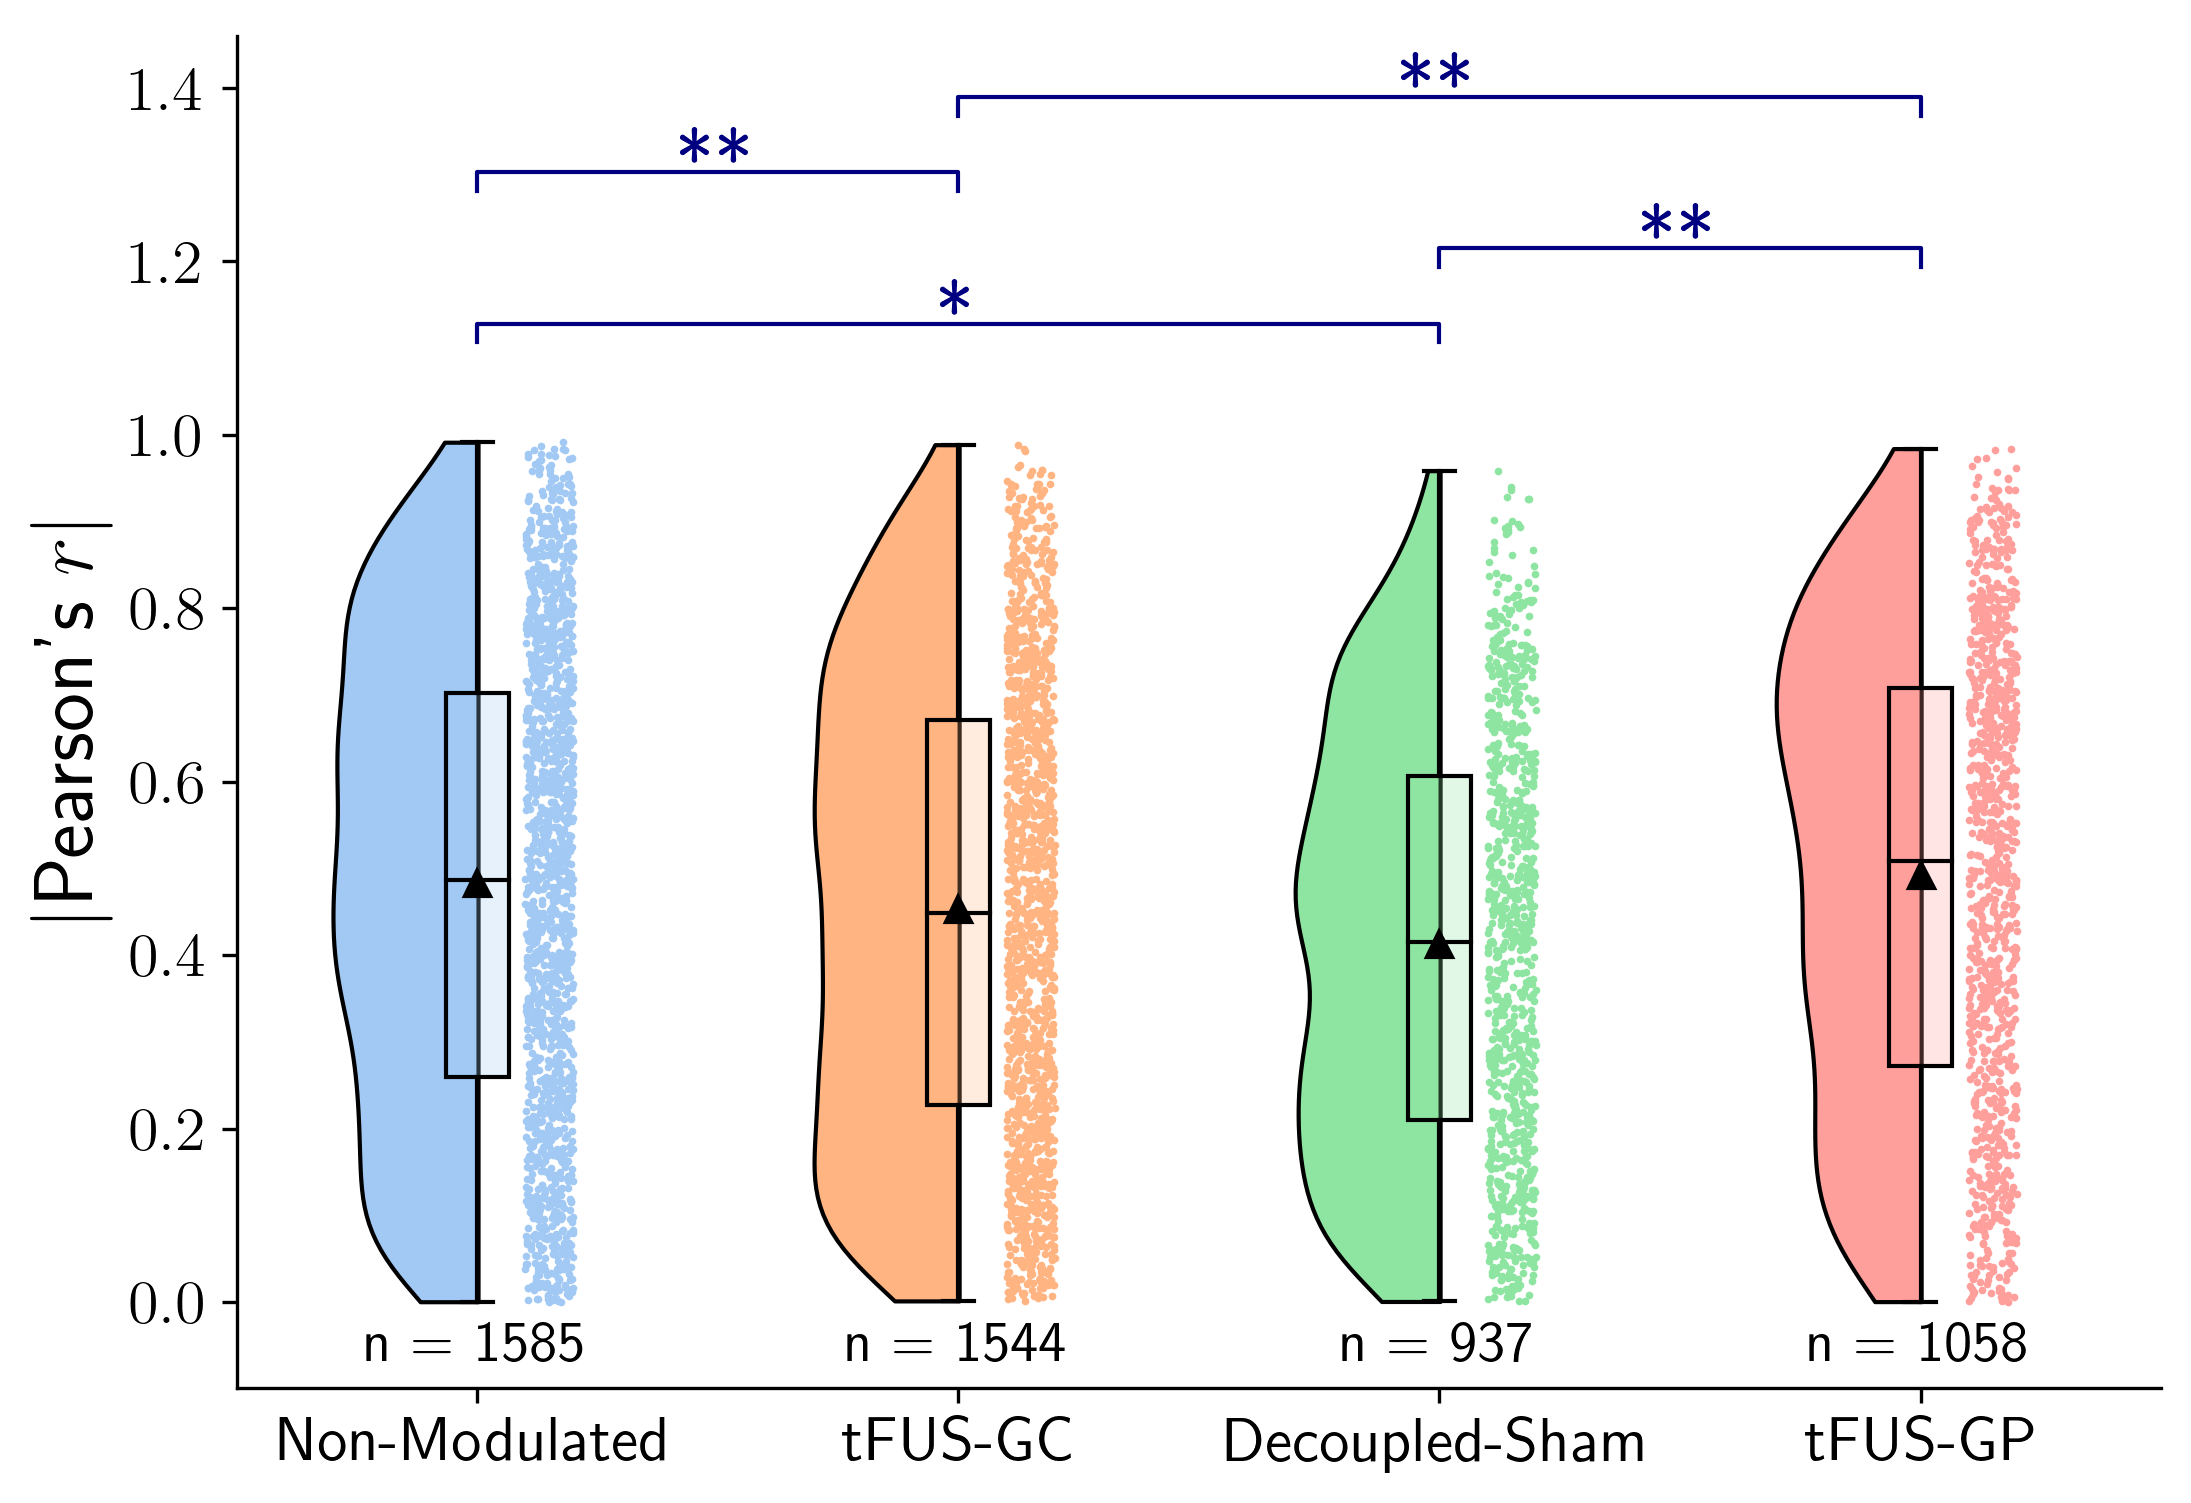

[]


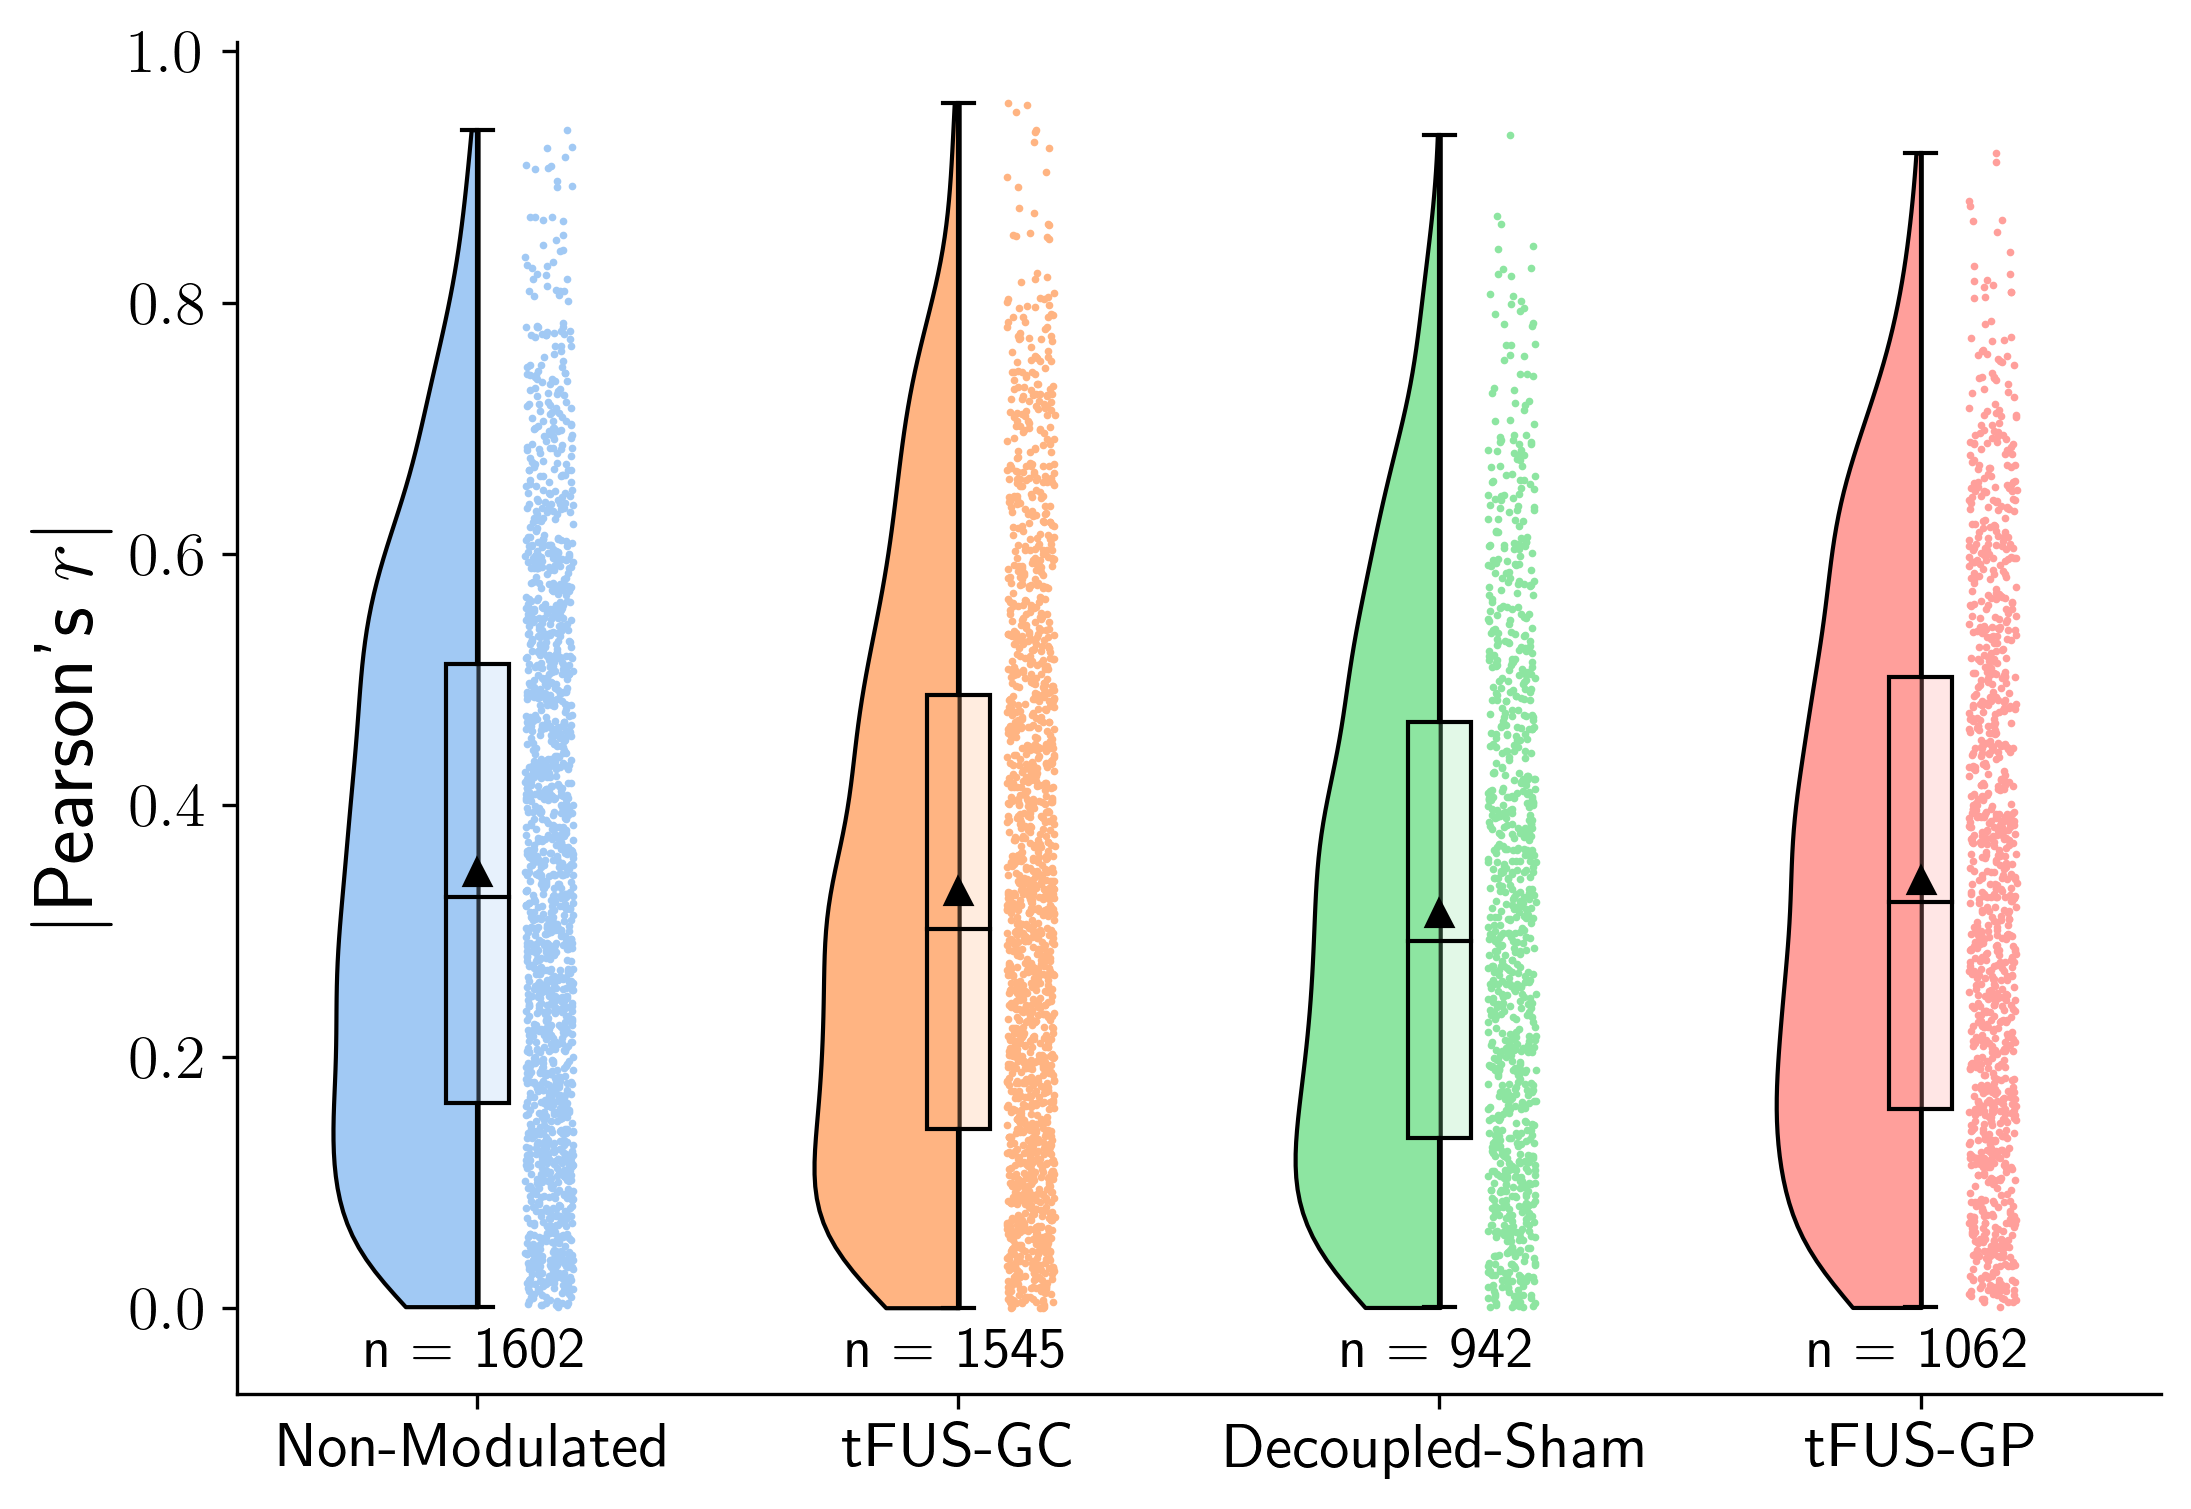

In [10]:
from Raincloud_Plot_Maker import statistical_box_and_whisker
import copy 

orig_keys = ["Non-Modulated", "tFUS-GC", "Decoupled-Sham", "tFUS-GP"]
keys = ["Non-Modulated", "tFUS-GC", "Decoupled-Sham", "tFUS-GP"]


dat_df = copy.deepcopy(connectivity_df)

# Hypothesis testing performed in R with linear mixed effect models. P-values were copied and pasted below
# in order to annotate the plots

if power == 'alpha':
    # ALPHA ps
    V5ITps = [
                [(2, 4), 0.005032413], # tFUS-US-Control
                [(2, 1), 0.008439660], # tFUS-NonModulated
                [(3, 4), 0.008427634], # US-Control - Decoupled Sham
                [(1, 3), 0.024097138], # Non-modulated - Decoupled-Sham
               ]

    V5SPps = []

else:    
    # THETA ps
    V5ITps = [
                [(2, 1), 0.001109219], # tFUS-NonModulated
                [(1, 3), 0.004889919], # Non-modulated - Decoupled-Sham
               ]


    V5SPps = [
                [(2, 3), 0.034903278], # tFUS-Decoupled
                [(3, 4), 0.034903278], # US-Control - Decoupled Sham
                [(1, 3), 0.004096398], # Non-modulated - Decoupled-Sham
               ]


ps = [V5ITps, V5SPps]


for i, loc in enumerate(["V5IT", "V5SP"]):
    data = []
    for j in range(len(keys)):
        data.append(dat_df['r'].loc[(dat_df.Connection == loc) & (dat_df.Condition == orig_keys[j])].values)


    statistical_box_and_whisker(data, keys,
                                plot_type='raincloud',
                                title = "", 
                                y_label=r"$|$Pearson's $r |$", 
                                p_adjustment = None,
                                print_ps = True, 
                                font = 'Arial',
                                show_means=True, 
                                passed_ps= True,
                                significant_combinations = ps[i],
                                sig_color='navy',
#                                 tails=1,
                                dpi = 300.0, 
                               save_fig = f"Corr_{loc}_{power}.svg")

In [9]:
np.unique(dat_df.Condition)

array(['Decoupled-Sham', 'Non-Modulated', 'tFUS-GC', 'tFUS-GP'],
      dtype=object)

In [ ]:
preprocessed_df